### Label propagation: segmentation using just position information

In [23]:
# Import Libraries
import os
from pathlib import Path
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [24]:
# Get the current working directory
cwd = os.getcwd()
print(cwd)

d:\VS_Projects\MIRA_MISA_LABS\MISA_LAB3


# Read new test images to perform the segmentation

In [25]:
# Read patients in the test-set
test_set_path = 'data/testing-set'
aux_patients_list = os.listdir(test_set_path + '/testing-images')
list_patient = []
for str1 in aux_patients_list:
    list_patient.append(str1.replace(".nii.gz", ""))

## Preprocessing -- Skull removal step
def skull_removal(img, mask):
    brain_mask = mask>=1
    skull_strip = img*(brain_mask)
    return skull_strip

# Save array as a new nifti image
def save_as_nifti(array, filename, reference_image):
    """Save array as nifti image

    Args:
        array (array): array to be saved
        filename (str): path to save
        reference_image (str): path of reference image
    """
    reference_image = sitk.ReadImage(reference_image)
    image = sitk.GetImageFromArray(array)
    image.SetOrigin(reference_image.GetOrigin())
    image.SetSpacing(reference_image.GetSpacing())
    image.SetDirection(reference_image.GetDirection())
    sitk.WriteImage(image, filename)

def image_registration(fixed_path, moving_path):
    """Give two images and the registration of both, and its transformation map will be given

    Args:
        fixed_path (str): fixed (template) image
        moving_path (str): moving image (image that will be transformed)

    Returns:
        sitk image, transformix map: transformed image and the transformation map
    """

    fixedImage = sitk.ReadImage(fixed_path)
    movingImage = sitk.ReadImage(moving_path)

    #Start registration settings
    elastixImageFilter = sitk.ElastixImageFilter() #Image filter object
    #Defining settings
    elastixImageFilter.SetFixedImage(fixedImage)
    elastixImageFilter.SetMovingImage(movingImage)

    #Run registration
    elastixImageFilter.Execute()

    #Get result image
    resultImage = elastixImageFilter.GetResultImage()

    #Transformation map
    transformParameterMap = elastixImageFilter.GetTransformParameterMap()
    #Set resampler interpolator as NearestNeighbor
    transformParameterMap[0]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    transformParameterMap[1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]    
    transformParameterMap[2]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    return resultImage, transformParameterMap

In [19]:
# fixed_path = str(cwd) + f'/data/testing-set/testing-images/1003.nii.gz'
# labels_path = str(cwd) + f'/data/testing-set/testing-labels/1003_3C.nii.gz'
# moving_path = str(cwd) + f'/data/training-set/training-images/1011.nii.gz'
# atlas_path_csf = str(cwd) + f'/data/our_atlas/csf_atlas.nii'
# atlas_path_gm = str(cwd) + f'/data/our_atlas/gm_atlas.nii'
# atlas_path_wm = str(cwd) + f'/data/our_atlas/wm_atlas.nii'

# resultImage, transformParameterMap = image_registration(fixed_path, moving_path) #Register images using predefined tranform map

# transformixImageFilter = sitk.TransformixImageFilter() #Create object transform matrix
# transformixImageFilter.SetTransformParameterMap(transformParameterMap) #Set with found transform map

# # TRansform atlas images to the same space as the fixed image
# atlas = sitk.ReadImage(atlas_path_csf) #Read labels
# transformixImageFilter.SetMovingImage(atlas) #set moving image
# transformixImageFilter.Execute() # Execute transform
# atlas_registered = transformixImageFilter.GetResultImage() #Get result image

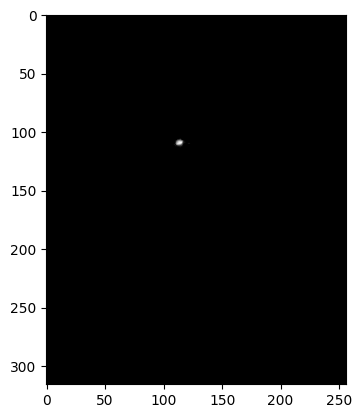

In [21]:
# plt.imshow(sitk.GetArrayFromImage(atlas_registered)[100,:,:], cmap='gray')

In [26]:
# TRansform atlas images to the same space as the fixed image per each image
atlas_path_csf = str(cwd) + f'/data/our_atlas/csf_atlas.nii'
atlas_path_gm = str(cwd) + f'/data/our_atlas/gm_atlas.nii'
atlas_path_wm = str(cwd) + f'/data/our_atlas/wm_atlas.nii'

def transform_atlas(atlas_path_csf, atlas_path_gm, atlas_path_wm, transformParameterMap):

    atlas_csf = sitk.ReadImage(atlas_path_csf) #Read labels
    atlas_gm = sitk.ReadImage(atlas_path_gm) #Read labels
    atlas_wm = sitk.ReadImage(atlas_path_wm) #Read labels
    
    transformixImageFilter = sitk.TransformixImageFilter() #Create object transform matrix
    transformixImageFilter.SetTransformParameterMap(transformParameterMap) #Set with found transform map
    transformixImageFilter.SetMovingImage(atlas_csf) #set moving image
    transformixImageFilter.Execute() # Execute transform
    atlas_csf_registered = transformixImageFilter.GetResultImage() #Get result image

    transformixImageFilter.SetMovingImage(atlas_gm) #set moving image
    transformixImageFilter.Execute() # Execute transform
    atlas_gm_registered = transformixImageFilter.GetResultImage() #Get result image

    transformixImageFilter.SetMovingImage(atlas_wm) #set moving image
    transformixImageFilter.Execute() # Execute transform
    atlas_wm_registered = transformixImageFilter.GetResultImage() #Get result image

    return atlas_csf_registered, atlas_gm_registered, atlas_wm_registered   
    
# Go through all the patients in the test-set
for patient in list_patient:
    print(patient)
    # Read the images
    fixed_path = str(cwd) + f'/data/testing-set/testing-images/{patient}.nii.gz'
    labels_path = str(cwd) + f'/data/testing-set/testing-labels/{patient}_3C.nii.gz'
    moving_path = str(cwd) + f'/data/training-set/training-images/1011.nii.gz'
    # Register the images
    resultImage, transformParameterMap = image_registration(fixed_path, moving_path)
    # Transform the atlas images
    atlas_csf_registered, atlas_gm_registered, atlas_wm_registered = transform_atlas(atlas_path_csf, atlas_path_gm, atlas_path_wm, transformParameterMap)
    # Save the transformed atlas images
    save_as_nifti(sitk.GetArrayFromImage(atlas_csf_registered), f'data/transformed_atlas/csf_atlas_{patient}.nii.gz', fixed_path)
    save_as_nifti(sitk.GetArrayFromImage(atlas_gm_registered), f'data/transformed_atlas/gm_atlas_{patient}.nii.gz', fixed_path)
    save_as_nifti(sitk.GetArrayFromImage(atlas_wm_registered), f'data/transformed_atlas/wm_atlas_{patient}.nii.gz', fixed_path)

1003
1004
1005
1018
1019
1023
1024
1025
1038
1039
1101
1104
1107
1110
1113
1116
1119
1122
1125
1128
